## Text Classification with BERT




In [1]:
### Instalando as dependências necessárias
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# ! pip install transformers
# # ! pip install torchviz
# ! pip install scikit-learn
# ! pip install ipywidgets
# Tratamento de dados
# ! pip install -U pip setuptools wheel
# ! pip install -U 'spacy'
# ! python -m spacy download en_core_web_sm

In [17]:
import re
import spacy
import torch
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.optim import AdamW
from transformers import (
    BertTokenizer,
    BertModel,
    get_linear_schedule_with_warmup,
)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

### Baixar CSV DAtaset

Caso você queira executar o modelo no colab, você deve baixar o conjunto de dados do IMDB no link abaixo e adiciona-lo a raiz do seu projeto:

<a href="https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews" target="_blank">Conjunto de dados IMDB de 50 mil críticas de filmes</a>


In [2]:
def load_imdb_data(data_path):
    df = pd.read_csv(data_path)
    df["sentiment"] = [
        1 if sentiment == "positive" else 0 for sentiment in df["sentiment"].tolist()
    ]
    return df

In [3]:
def load_texts_labels(df):
    texts = df["review"].tolist()
    labels = df["sentiment"].tolist()
    return texts, labels

In [5]:
DATA_PATH = "D:/tcc2/guilherme/1_Exemplos_estudos/data/IMDB Dataset.csv"
df = load_imdb_data(DATA_PATH)


In [8]:
df.duplicated().sum()

418

In [10]:
df = df.drop_duplicates()
# df = df[:49_500]  # definir tamanho do df para
df.duplicated().sum()

0

In [13]:
df["review"].size

49582

In [14]:
def maior_text(texts):
    return max(texts, key=lambda x: len(x.split()))

In [18]:
texts, labels = load_texts_labels(df)
maior_string = maior_text(texts)
tam_maior_string = len(maior_string)
print(tam_maior_string)

13704


In [19]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label),
        }

In [10]:
# # original
# class MultiClassClassifier(nn.Module):
#     def __init__(self, bert_model_name: str, hidden_size: int, num_classes: int):
#         super(MultiClassClassifier, self).__init__()
#         self.bert = BertModel.from_pretrained(bert_model_name)
#         self.dropout = nn.Dropout(0.1)
#         self.linear1 = nn.Linear(self.bert.config.hidden_size, hidden_size)
#         self.linear2 = nn.Linear(hidden_size, num_classes)
#         # self.softmax = nn.Softmax(dim=1)

#     def forward(self, input_ids, attention_mask):
#         outputs_bert = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#         pooled_output = outputs_bert.pooler_output
#         x = self.dropout(pooled_output)
#         logits = self.linear1(x)
#         logits = self.linear2(logits)
#         # probs = self.softmax(logits)
#         return logits

In [11]:
# original com funcoes de ativacao relu

class MultiClassClassifier(nn.Module):
    def __init__(self, bert_model_name: str, hidden_size: int, num_classes: int):
        super(MultiClassClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.linear1 = nn.Linear(self.bert.config.hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        outputs_bert = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs_bert.pooler_output
        drop = F.relu(self.dropout(pooled_output))
        logits = F.relu(self.linear1(drop))
        logits = F.relu(self.linear2(logits))
        # probs = self.softmax(logits)
        return logits

In [12]:
# 89% de precisão final
# import torch.nn.functional as F 
# class MultiClassClassifier(nn.Module):
#     def __init__(self, bert_model_name: str, hidden_size: int, num_classes: int):
#         super(MultiClassClassifier, self).__init__()
#         self.bert = BertModel.from_pretrained(bert_model_name)
#         self.dropout = nn.Dropout(0.1)
#         self.linear1 = nn.Linear(self.bert.config.hidden_size, 64)
#         self.linear2 = nn.Linear(64, 32)
#         self.linear3 = nn.Linear(32, 16)
#         self.linear4 = nn.Linear(16, num_classes)  # Alterei para num_classes para tornar o modelo mais flexível

#     def forward(self, input_ids, attention_mask):
#         outputs_bert = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#         pooled_output = outputs_bert.pooler_output
#         x = self.dropout(pooled_output)
#         x = F.relu(self.linear1(x))  # Adicionei a função de ativação ReLU
#         x = F.relu(self.linear2(x))  # Adicionei a função de ativação ReLU
#         x = F.relu(self.linear3(x))  # Adicionei a função de ativação ReLU
#         logits = self.linear4(x)  # Esta é a camada de saída, então não aplicamos ReLU aqui
#         return logits


In [14]:
def train(model: MultiClassClassifier, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()  # Atualiza os pesos do modelo usando os gradientes calculados.
        scheduler.step()  # Atualiza a taxa de aprendizado. Isso é feito após cada época

In [ ]:
def train_model_epoch(
    model: MultiClassClassifier, data_loader, optimizer, scheduler, loss_func, device
):
    model.train()
    losses = []
    model_prediction = []
    actual_labels = []
    for batch in tqdm(data_loader, colour="green", desc="Train_epoch: "):
    
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = loss_func(outputs, labels)
        loss.backward()
        losses.append(loss.item())

        _, preds = torch.max(outputs, dim=1)
        model_prediction.extend(preds.cpu().tolist())
        actual_labels.extend(labels.cpu().tolist())

        optimizer.step()
        scheduler.step()

    train_accuracy = accuracy_score(actual_labels, model_prediction)
    train_loss = np.mean(losses)


    return train_accuracy, train_loss

In [15]:
def evaluate(model: MultiClassClassifier, data_loader: TextClassificationDataset, device: str):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():  
        for batch in tqdm(data_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(
                outputs, dim=1
            )  # Obtém as previsões do modelo encontrando o índice do valor máximo na saída do modelo.
            predictions.extend(
                preds.cpu().tolist()
            )  # Adiciona as previsões  a predictions[]
            actual_labels.extend(
                labels.cpu().tolist()
            )  # Adiciona os rótulos reais a actual_labels[].
    return accuracy_score(actual_labels, predictions), classification_report(
        actual_labels, predictions
    )

In [ ]:
def eval_model_epoch(
    model: MultiClassClassifier, data_loader: TextClassificationDataset,loss_func, device: str
):
    model.eval()
    losses = []
    model_prediction = []
    actual_labels = []
    correct_predictions = 0
    with torch.no_grad():
        for batch in tqdm(data_loader, colour="blue", desc="Validation_epoch: "):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # Obtém as previsões do modelo encontrando o índice do valor máximo na saída do modelo.
            _, preds = torch.max(outputs, dim=1)
            # Adiciona as previsões a model_prediction[] lista de predicao de sentimento do modelo
            model_prediction.extend(preds.cpu().tolist())
            # Adiciona os rótulos reais a actual_labels[].
            actual_labels.extend(labels.cpu().tolist())
            correct_predictions += torch.sum(preds == labels)
            # Calcula a perda e adiciona à lista de perdas
            loss = loss_func(outputs, labels)
            losses.append(loss.item())
    val_losses = np.mean(losses)
    val_accuracies = accuracy_score(actual_labels, model_prediction)
    report = classification_report(actual_labels, model_prediction)
    return (val_accuracies, val_losses, report)

In [18]:
# Set up parameters
BERT_MODEL_NAME = "bert-base-uncased"
hidden_size = 10 #Tamanho oculto, neuronios
num_classes = 2 # numero de neuronios saida/ categorias
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 5e-5

In [19]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [20]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
train_dataset = TextClassificationDataset(
    train_texts, train_labels, tokenizer, max_length
)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

d:\tcc2\guilherme\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiClassClassifier(BERT_MODEL_NAME,hidden_size, num_classes).to(device)

In [22]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
#: Isso configura o agendador de taxa de aprendizado. O agendador ajusta a taxa de aprendizado ao longo do treinamento. Neste caso, a taxa de aprendizado aumentará linearmente por um número de etapas de aquecimento e, em seguida, diminuirá linearmente.
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

In [23]:
# Equivalente a Funcao fit()
for epoch in tqdm(range(num_epochs), colour="green", desc="Progresso: "):

    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

Progresso:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4


## Saving & Loading Model for Inference

Save:


In [ ]:
# PATH_MODEL_SAVE = "sentiment_classifier_Bert_IMDB_Dataset_sem_lemma.pth"
# torch.save(model.state_dict(), PATH_MODEL_SAVE)

load:


In [ ]:
# # PATH_MODEL_SAVE = "sentiment_classifier_en_49500_reviews.pth"
# saved_model = MultiClassClassifier(BERT_MODEL_NAME,hidden_size, num_classes).to(device)
# saved_model.load_state_dict(torch.load(PATH_MODEL_SAVE))
# # saved_model.eval()

## Prediction sentiment in data test

In [ ]:
DATA_PATH = "D:/tcc2/guilherme/3_tratamento_dados/dataset_tratado/Scraper_Dataset_tretead_text.csv"
df = pd.read_csv(DATA_PATH)
df = df[['review','rating']]
df


,review,rating
0,movie takes place fantasy land absolutely ridi...,1
1,sentimental pathetic slow conventionally voice...,1
2,things life understand universe begin happens ...,1
3,movie inspired brilliant stir crazy starring g...,1
4,life understand gushing cornball sentimental p...,1
...,...,...
44405,uma thurman returns bride time looks continue ...,10
44406,quentin tarantino kill bill vol 2 completes 2 ...,10
44407,vol 2 completely different tone features film ...,10
44408,movie great mixes different genres movies mart...,10


In [ ]:
# # Para Classe Positivo[7,8,9,10] e Negativo [...]
def categorize_rating(rating):
    if int(rating) <= 6:
        return 0
    else:
        return 1

In [ ]:
def load_texts_labels(df):
    texts = df["review"].tolist()
    labels = df["rating"].tolist()
    return texts, labels

In [ ]:
df['rating'] = df['rating'].apply(categorize_rating)



In [ ]:
print(df['rating'].value_counts())

rating
1    24471
0    19939
Name: count, dtype: int64


In [ ]:
test_texts, test_labels = load_texts_labels(df)


In [ ]:

test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer, max_length)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
test_dataloader

In [ ]:


def get_predictions(model, data_loader):
    model = model.eval()

    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            # review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, prediction_probs, real_values

In [ ]:
predictions,prediction_probs,real_values = get_predictions(model, test_dataloader)
# print(val_accuracy)
# print(report)

In [ ]:
df['rating'].value_counts()

rating
1    24471
0    19939
Name: count, dtype: int64

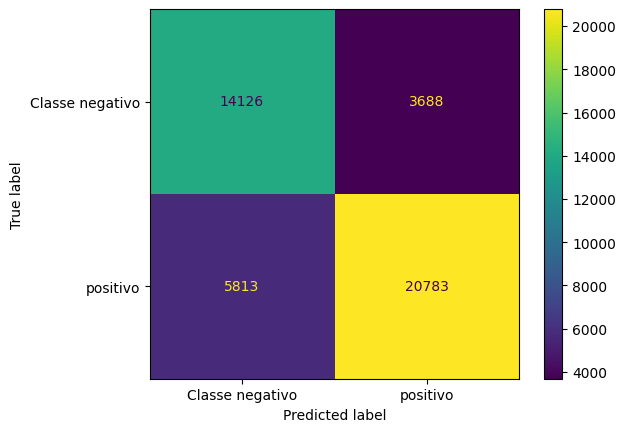

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  
classes_names = ['Classe negativo','positivo']  
cm = confusion_matrix(predictions,real_values)
# df_cm = pd.DataFrame(cm, index=classes_names, columns=classes_names)
# show_confusion_matrix(df_cm)
cm_display = ConfusionMatrixDisplay(cm,display_labels=classes_names).plot()


In [ ]:
cm

array([[14126,  3688],
       [ 5813, 20783]], dtype=int64)

In [ ]:
def predict_tratamento_texto(text: str, lemma:bool):
    nlp = spacy.load("en_core_web_sm", exclude=["parser", "ner"])
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(re.compile("<.*?>"), "", text)
    doc = nlp(text)
    if lemma == True:
        text = " ".join(
            [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        )  # retorna o lemma
    else:
        text = " ".join(
            [token.text for token in doc if not token.is_stop and not token.is_punct]
        )  # return text
    return text



In [ ]:

def predict_sentiment(
    text: str, model: MultiClassClassifier, tokenizer: BertTokenizer, device: str, max_length: int
):
    model.eval()
    text = predict_tratamento_texto(text, lemma=False)
    encoding = tokenizer(
        text,
        return_tensors="pt",
        max_length=max_length,
        padding="max_length",
        truncation=True,
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        prob = model(input_ids=input_ids, attention_mask=attention_mask)

    prob_neg = prob[0, 0].item()
    prob_pos = prob[0, 1].item()
    print(f"prob negativa: {prob_neg:.5f}")
    print(f"prob positiva: {prob_pos:.5f}")

    if prob_neg >= 0.7 and prob_pos < 0.6:
        return "negative"
    elif prob_neg < 0.6 and prob_pos >= 0.7:
        return "positive"
    else:
        return "neutral"

In [ ]:
# Capita marvel 2019 5/10
text = """
    Plot

Carol Danvers     becomes one of the universe's most powerful heroes when Earth is caught in the middle of a galactic war between two alien races.

Cast

Brie Larson, Samuel L. Jackson (Because duh), Jude "Just consistently dreadful" Law, Annette Bening, Djimon Hounsou, Clark Gregg and blink and you'll miss him Lee Pace who returns as Ronan but looks so different I didn't even think it was him.

Verdict

I watched this back when it was initially released, I watched it a second time a few days ago as the missus is wanting us to binge watch the entire MCU as she's very behind. My opinion has changed on the 2nd viewing and not in a good way, my rating has shifted from a 6/10 to 5/10.

You see straight out of the gate the first thing you notice about Carol Danvers is she's not really a character you can get behind. She's not funny, she's not entertaining, she comes across as a surly teenage girl who is just upset at the slightest thing and just doesn't want to be there. This is not a character you can build a movie around, like trying to make a teenage Groot movie! It wouldn't work, but he's okay as a side character.

Supporting cast are also hit and miss, Jackson and Gregg are great, but Lynch and Law just stink up every scene they're in.

I'm a Marvel fan but I recognize where it's weak, this is a distinctly average film that serves as a standalone origin story and doesn't contribute much to the universe as a whole.

Rants

I remember when the movie came out all the controversy with Brie Larson, I just had to Google what the controversy even was as I don't remember due to not focusing on such things. Now I can't really get a definitive answer. From what I see it's a combination of people not liking her attitude and her comments on feminism. So I Googled further to see what she said, she came across arrogant in them and a smidge out of touch but none of it explained the overwhelming hate I've seen aimed at her. Then I remembered that people talk about all the different types of bigotry but misogyny rarely comes up, I remembered that it's visibly increased over the past decade and appreciated why she's been targeted. News flash, the outspoken loud brash man hating femnists you likely thing of when you hear that word make up a very small percentage. Feminism is good, if you disagree I hope you simply don't know the meaning of the word.

The Good

Jackson and Gregg Has a couple of decent moments Not a bad soundtrack Goose!

The Bad

Larson isn't great Law and Lynch are terrible Lead just comes across unlikable.

Overall just a weak entry to the MC
"""

In [ ]:
# Test sentiment prediction
# test_text = " very perfect very good very bad bad well, "
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
# sentiment2 = predict_sentiment(text, saved_model, tokenizer, device, max_length)

print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")
# print(f"Predicted sentiment: {sentiment2}")

prob negativa: -0.12096
prob positiva: -1.06426
plot carol danvers universe powerful heroes earth caught middle galactic war alien races cast brie larson samuel l. jackson duh jude consistently dreadful law annette bening djimon hounsou clark gregg blink miss lee pace returns ronan looks different think verdict watched initially released watched second time days ago missus wanting binge watch entire mcu opinion changed 2nd viewing good way rating shifted 6/10 5/10 straight gate thing notice carol danvers character funny entertaining comes surly teenage girl upset slightest thing want character build movie like trying teenage groot movie work okay character supporting cast hit miss jackson gregg great lynch law stink scene marvel fan recognize weak distinctly average film serves standalone origin story contribute universe rants remember movie came controversy brie larson google controversy remember focusing things definitive answer combination people liking attitude comments feminism go

In [ ]:
# CApita marvel 2019 6/10
text="""Mediocre Marvel is still pretty good.

My first review in a long time! Dont know why I decided to write about this movie.

I agree with most mediocre reviews I read here.

The pacing was pretty good.

Most of the action was good!

The story was ok and had some good twists.

I thought about giving this movie a 6 but after letting it sink in I decided to give it 8 out of 10

It entertained me and my company from beginning to end.

There were some eye rolling moments but they are easily forgiven."""

In [ ]:
# Test sentiment prediction
# test_text = " very perfect very good very bad bad well, "
sentiment = predict_sentiment(text, model, tokenizer, device, max_length)
# sentiment2 = predict_sentiment(text, saved_model, tokenizer, device, max_length)

print(predict_tratamento_texto(text,lemma= False))
print(f"Predicted sentiment: {sentiment}")
# print(f"Predicted sentiment: {sentiment2}")

prob negativa: -1.28002
prob positiva: 2.99175
mediocre marvel pretty good review long time nt know decided write movie agree mediocre reviews read pacing pretty good action good story ok good twists thought giving movie 6 letting sink decided 8 10 entertained company beginning end eye rolling moments easily forgiven
Predicted sentiment: positive


In [ ]:
# Test sentiment prediction
test_text = "The movie was so bad and I would not recommend it to anyone."
sentiment = predict_sentiment(test_text, model, tokenizer, device, max_length)
print("Texto: ", test_text)
print(f"Predicted sentiment: {sentiment}")

prob negativa: 1.53548
prob positiva: -3.72699
Texto:  The movie was so bad and I would not recommend it to anyone.
Predicted sentiment: negative


In [ ]:
# Test sentiment prediction
test_text = "Best movie of the year. "
sentiment = predict_sentiment(test_text, model, tokenizer, device, max_length)
print("Worst movie of the year.")
print(f"Predicted sentiment: {sentiment}")

prob negativa: -1.45016
prob positiva: 3.68990
Worst movie of the year.
Predicted sentiment: positive


In [ ]:
# Test sentiment prediction
test_text = "This movie is more or less very hungry"
sentiment = predict_sentiment(test_text, model, tokenizer, device, max_length)
print(test_text)
print(f"Predicted sentiment: {sentiment}")

prob negativa: 1.11350
prob positiva: -2.97030
This movie is more or less very hungry
Predicted sentiment: negative


### Listar tensores na GPU e CPU


In [ ]:
import torch
import gc


# Função para listar tensores na GPU
def get_tensors_in_gpu():
    print("\nTensores na GPU:")
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            if obj.is_cuda:
                print(type(obj), obj.size(), obj.device)
# Listar tensores na GPU
get_tensors_in_gpu()
torch.cuda.empty_cache()



Tensores na GPU:
<class 'torch.Tensor'> torch.Size([30522, 768]) cuda:0
<class 'torch.Tensor'> torch.Size([30522, 768]) cuda:0
<class 'torch.Tensor'> torch.Size([512, 768]) cuda:0
<class 'torch.Tensor'> torch.Size([512, 768]) cuda:0
<class 'torch.Tensor'> torch.Size([2, 768]) cuda:0
<class 'torch.Tensor'> torch.Size([2, 768]) cuda:0
<class 'torch.Tensor'> torch.Size([768]) cuda:0
<class 'torch.Tensor'> torch.Size([768]) cuda:0
<class 'torch.Tensor'> torch.Size([768]) cuda:0
<class 'torch.Tensor'> torch.Size([768]) cuda:0
<class 'torch.Tensor'> torch.Size([768, 768]) cuda:0
<class 'torch.Tensor'> torch.Size([768, 768]) cuda:0
<class 'torch.Tensor'> torch.Size([768]) cuda:0
<class 'torch.Tensor'> torch.Size([768]) cuda:0
<class 'torch.Tensor'> torch.Size([768, 768]) cuda:0
<class 'torch.Tensor'> torch.Size([768, 768]) cuda:0
<class 'torch.Tensor'> torch.Size([768]) cuda:0
<class 'torch.Tensor'> torch.Size([768]) cuda:0
<class 'torch.Tensor'> torch.Size([768, 768]) cuda:0
<class 'torch.T

d:\tcc2\guilherme\.venv\Lib\site-packages\torch\distributed\distributed_c10d.py:366: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(
